In [75]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cv2

plt.rcParams['figure.figsize'] = (9, 7)


## Load and plot image

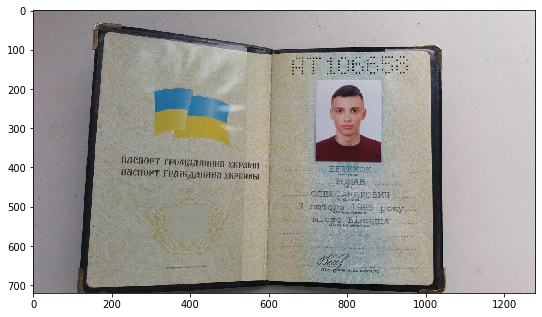

In [77]:
IMG_PATH = 'images/3.jpg'
img = cv2.imread(IMG_PATH)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

## Edge detection

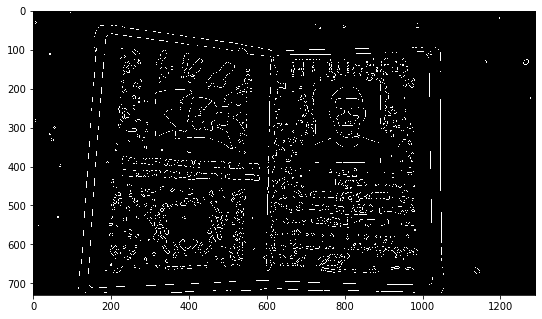

In [80]:
MIN_VAL = 200
MAX_VAL = 250

def detect_edges(img, min_val=MIN_VAL, max_val=MAX_VAL):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply filter, threshold and blur
    img = cv2.bilateralFilter(img, 9, 75, 75)
    img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 115, 4)
    img = cv2.medianBlur(img, 5)

    # Add border
    img = cv2.copyMakeBorder(img, 5, 5, 5, 5, cv2.BORDER_CONSTANT, value=[0, 0, 0])

    # Apply Canny edge detector
    img = cv2.Canny(img, min_val, max_val)

    return img

edges_img = detect_edges(img)
plt.imshow(edges_img, cmap='gray')
    

In [54]:
ret3

127.0